In [2]:
%pip install optuna
%pip install pandas
%pip install numpy 
%pip install matplotlib
%pip install seaborn 
%pip install sklearn
%pip install keras
%pip install scikit-learn
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfi

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-11-06 23:08:22.307104: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-06 23:08:22.307269: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 23:08:22.330057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-06 23:08:22.836551: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different compu

In [4]:
import os
print(os.getcwd())
df = pd.read_csv('data-bitcoin_timedata_v2.csv')

df.head()
df.info()

/home/pedro/Code/lstm_pcgr
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              2176 non-null   object 
 1   open              2176 non-null   float64
 2   high              2176 non-null   float64
 3   low               2176 non-null   float64
 4   close             2176 non-null   float64
 5   number_of_trades  2176 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 102.1+ KB


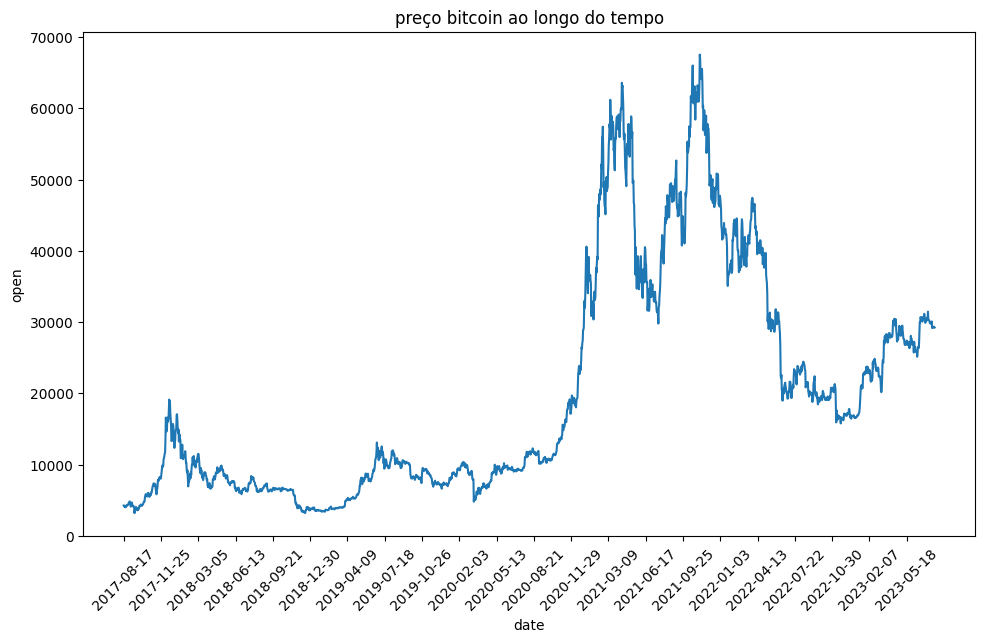

In [5]:
# Gráfico de Linhas para Preços de Abertura ao longo do tempo
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='open', data=df)
plt.title('preço bitcoin ao longo do tempo')
plt.tight_layout()
plt.xticks(df['date'][::100], rotation=45)
plt.show()

In [6]:
# Train-Test Split (80-20)

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Split temporal: treino->validação->teste
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

# Separar dados mantendo ordem temporal
train_data = df[:train_size]
test_data = df[train_size:]

# Fit scaler APENAS nos dados de treino
scaler = StandardScaler()
scaler.fit(train_data['close'].values.reshape(-1, 1))

# Transform separadamente
train_scaled = scaler.transform(train_data['close'].values.reshape(-1, 1))
test_scaled = scaler.transform(test_data['close'].values.reshape(-1, 1))

# Criar sequências
sequence_length = 14
def create_sequences(data):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)

In [7]:
# 2. Model Definition and Compilation
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define model
model = Sequential([
    LSTM(10, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(10),
    Dropout(0.2),
    Dense(1)
])

# Compile model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.summary()

E0000 00:00:1762481304.139403   29660 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1762481304.142905   29660 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/pedro/Code/lstm_pcgr/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 10)         │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331 (5.20 KB)

 Trainable params: 1,331 (5.20 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Model Training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1051 - val_loss: 0.0874
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0355 - val_loss: 0.0598
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0302 - val_loss: 0.0580
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0329 - val_loss: 0.0364
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259 - val_loss: 0.0321
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0280 - val_loss: 0.0891
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0267 - val_loss: 0.0804
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251 - val_loss: 0.0513
Epoch 9/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0247 - val_loss: 0.0274
Epoch 10/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0273 - val_loss: 0.1550
Epoch 11/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0278 - val_loss: 0.0298
Epoch 12/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225 - val_lo

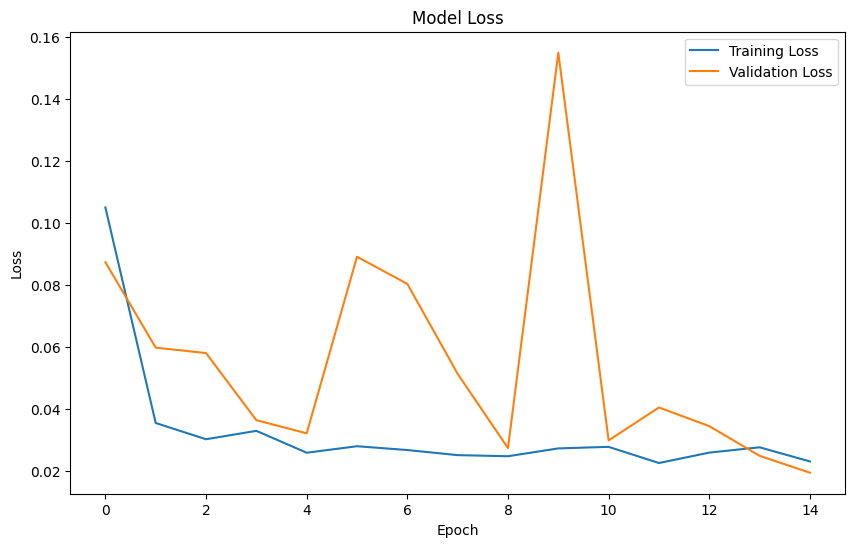

In [9]:
# Plot Training History
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


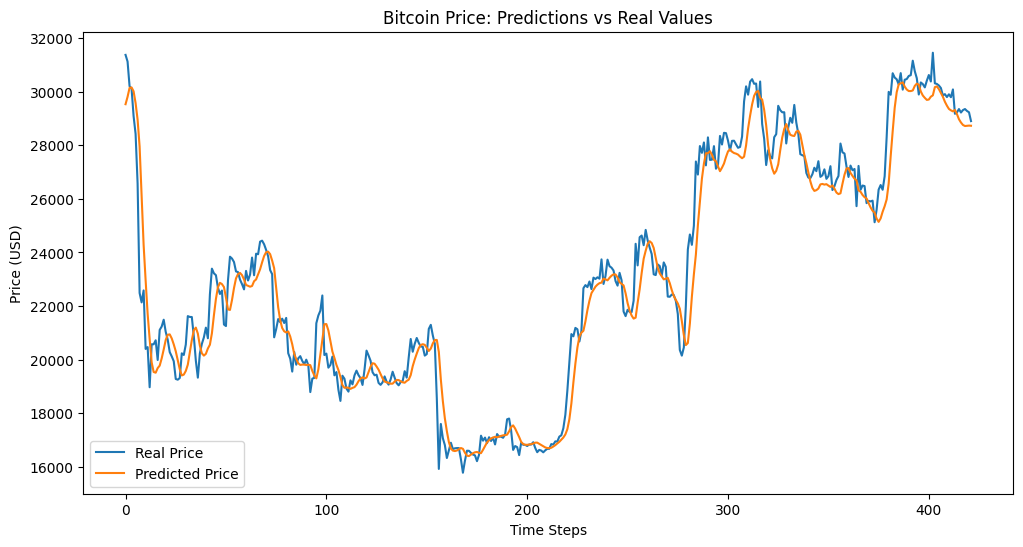

Root Mean Square Error: 0.0558
Mean Absolute Error: 0.0383
R² Score: 0.9506


In [10]:
# Make Predictions
predictions = model.predict(X_test)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_test), label='Real Price')
plt.plot(scaler.inverse_transform(predictions), label='Predicted Price')
plt.title('Bitcoin Price: Predictions vs Real Values')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Calculate error metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Root Mean Square Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


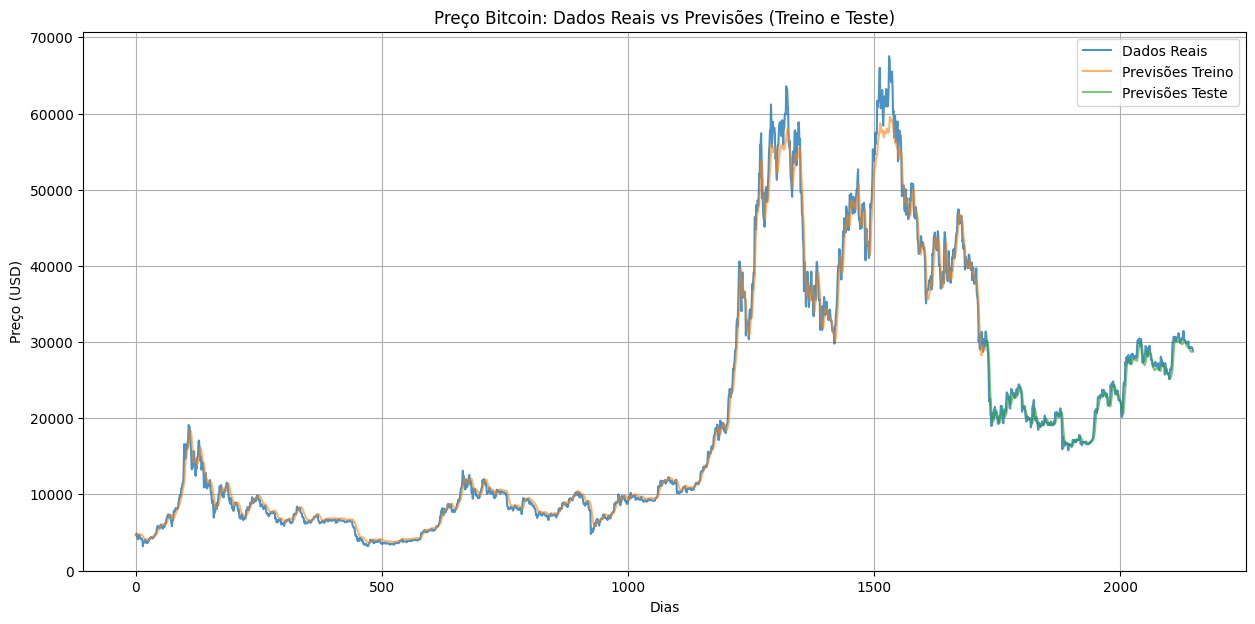

In [11]:
# Fazer previsões tanto no conjunto de treino quanto teste
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Criar arrays para plotagem
# Dados reais completos
real_prices = np.concatenate([
    scaler.inverse_transform(y_train), 
    scaler.inverse_transform(y_test)
])

# Previsões (None para dados não previstos)
train_plot = np.concatenate([
    scaler.inverse_transform(train_predictions),
    np.array([[None]] * len(y_test))
])

test_plot = np.concatenate([
    np.array([[None]] * len(y_train)),
    scaler.inverse_transform(test_predictions)
])

# Plotar
plt.figure(figsize=(15, 7))
plt.plot(real_prices, label='Dados Reais', alpha=0.8)
plt.plot(train_plot, label='Previsões Treino', alpha=0.6)
plt.plot(test_plot, label='Previsões Teste', alpha=0.6)
plt.title('Preço Bitcoin: Dados Reais vs Previsões (Treino e Teste)')
plt.xlabel('Dias')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()